<a href="https://colab.research.google.com/github/moch1996/Vaycold/blob/main/Recommend_Algorithm/%EA%B0%84%EB%8B%A8%ED%95%9C%20%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 간단한 추천시스템 만들기
  - ### 목표 : 특정유저가 특정영화에 몇점을 주었는가??
  - 간단한 추천알고리즘 만들기
  - 평점을 예측하고 RMSE로 평가

## 라이브러리 정의

In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir('drive/MyDrive/fastcampus/recommend/movielens')

['ratings.csv', 'tags.csv', 'movies.csv', 'README.txt', 'links.csv']

In [ ]:
path = '/content/drive/MyDrive/fastcampus/recommend/movielens'

In [ ]:
# 데이터 불러오기

ratings_df = pd.read_csv(os.path.join(path,'ratings.csv'), encoding='utf-8')
movies_df = pd.read_csv(os.path.join(path,'movies.csv'), index_col = 'movieId', encoding='utf-8')
tags_df = pd.read_csv(os.path.join(path,'tags.csv'), encoding='utf-8')

In [ ]:
print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


## 데이터 탐색

In [24]:
# Ratings data를 주로 확인할 계획

In [34]:
# 몇 명의 유저가 몇 개의 영화에 평점을 주었는 지 확인해보자
num_users = len(ratings_df.userId.unique())
print('총 유저 수 : ',num_users,'명')

num_movies = len(ratings_df.movieId.unique())
print('총 영화 수 : ',num_movies,'편')


총 유저 수 :  610 명
총 영화 수 :  9724 편


In [36]:
# 각 유저가 어떤 영화에 평점을 몇점 주었는지 확인해보자
# 피벗테이블을 이용하자

user_movie_matrix = ratings_df.pivot(
    index = 'movieId',
    columns = 'userId',
    values = 'rating',
  ).fillna(0) #결측값은 0으로 두자

In [38]:
user_movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# sparse matrix로 옮겨서 확인해보자
sparse_mat = csr_matrix(user_movie_matrix.values)
print(sparse_mat) # 점수가 있는 것만 출력하는 매트릭스

  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (9700, 337)	2.5
  (9701, 337)	3.0
  (9702, 183)	4.0
  (9702, 247)	3.5
  (9703, 317)	2.5
  (9704, 209)	1.0
  (9705, 461)	2.5
  (9706, 49)	3.5
  (9707, 337)	1.5
  (9708, 337)	4.0
  (9709, 337)	1.0
  (9710, 337)	1.5
  (9711, 337)	1.0
  (9712, 337)	1.0
  (9713, 183)	4.5
  (9714, 183)	3.5
  (9715, 183)	3.0
  (9716, 183)	4.0
  (9717, 183)	4.0
  (9718, 183)	3.5
  (9719, 183)	4.0
  (9720, 183)	3.5
  (9721, 183)	3.5
  (9722, 183)	3.5
  (9723, 330)	4.0


In [43]:
user_movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# 각 유저가 평점을 내린 영화는 몇개인지 확인해보자
# - list( value_counts)를 했을 때는 인덱싱 값 제외하고 내림차순으로 list형식으로 반환된다!! 참고!!
# - List comprehension을 사용하자!
# - value_counts()를 사용하면 내림차순으로 결과가 나온다. 이를 이용하여 0이 가장 많을테니 [1:]로 인덱싱하여 0을 제거한 수를 알아 낼 수 있다.

In [86]:
user_info_df = pd.DataFrame(
    data = [
            sum(list(user_movie_matrix[int(x)].value_counts())[1:]) for x in user_movie_matrix.columns
    ],
    index = user_movie_matrix.columns,
    columns = ['movie_rated']
)
user_info_df

,movie_rated
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


In [87]:
# 같은 방식으로 각 영화는 몇 번씩 선택받았는지 확인해보자
# 그 행의 모든 값들을 가져와야 되므로 df.loc[]를 사용하자

In [130]:
user_movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.5,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
movie_info_df = pd.DataFrame(
    data = [
            sum(list(user_movie_matrix.loc[int(x)].value_counts())[1:]) for x in user_movie_matrix.index
    ],
    index = user_movie_matrix.index,
    columns = ['users_rated']
)
movie_info_df

,users_rated
movieId,
1,215
2,110
3,52
4,7
5,49
...,...
193581,1
193583,1
193585,1


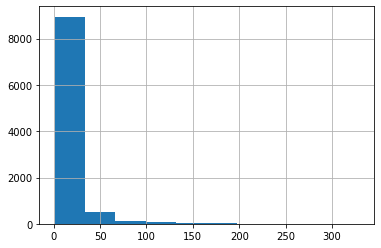

In [151]:
movie_info_df.users_rated.sort_values(ascending=False).hist()

# 데이터가 편향되있다. 즉 대부분의 영화들이 평점이 하나만 가지고 있다고 봐도 무방하다. 

## Training Set & Test set

In [152]:
train_df, test_df = train_test_split(ratings_df, test_size = 0.2 ,random_state = 1234)

In [153]:
print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [161]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [159]:
train_df.head(5)

,userId,movieId,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


In [160]:
test_df.head(5)

,userId,movieId,rating,timestamp
99731,610,3527,5.0,1479545223
97583,606,1250,3.5,1171376891
38197,262,213,5.0,840310907
11474,68,69406,3.0,1261622505
34105,232,4728,3.0,1218166950


In [162]:
# 여기서 생각해봐야 할 점
# - 단순히 랜덤하게 나눈다고 했을 때 트레이닝 셋에는 1번 유저가 있지만 테스트 셋에는 1번 유저가 없을 수 도 있는 상황이 만들어 질 수 있음.

In [ ]:
# test 셋에는 존재하지만 training 셋에는 없는 영화 또는 사용자 비율을 알아보자

# - userId

In [ ]:
test_df['userId'].unique() # test셋의 userid 고유한 수를 보여줌

In [169]:
set(test_df['userId'].unique()) # 그 고유한 것을 set을 통해 하나의 배열??세트??로 만들어줌

AttributeError: ignored

In [174]:
# 트레이닝 셋도 똑같이 한 후 테스트 셋에서 빼줌
set(test_df['userId'].unique()) - set(train_df['userId'].unique())


set()

In [175]:
# 뭐여 다 있네 순간 오류난 줄
list(set(test_df['userId'].unique()) - set(train_df['userId'].unique()))

[]

In [176]:
len(list(set(test_df['userId'].unique()) - set(train_df['userId'].unique())))

0

In [177]:
print('사용자 : ',len(list(set(test_df['userId'].unique()) - set(train_df['userId'].unique()))))

사용자 :  0


In [182]:
# 영화도 해보자
test_df.movieId.unique()

array([3527, 1250,  213, ..., 5268, 3925, 2328])

In [183]:
train_df.movieId.unique()

array([ 5943,  2571,  8958, ..., 26861,  6814,  6279])

In [ ]:
set(test_df.movieId.unique())

In [ ]:
set(train_df.movieId.unique())

In [187]:
len(list(set(test_df.movieId.unique())-set(train_df.movieId.unique())))

# 얜 쫌 많다..

786

In [192]:
print('영화 : ',len(list(set(test_df.movieId.unique())-set(train_df.movieId.unique())))
)

print('테스트 셋의 영화 수 : ', len(test_df.movieId.unique()) )

영화 :  786
테스트 셋의 영화 수 :  5171


In [193]:
# 그렇다면 포함이 안된 영화는 어떤 것들인지 보자

movies_not_included = list(set(test_df.movieId.unique())- set(train_df.movieId.unique()))

In [197]:
print(sorted(movies_not_included[:10]))

[6145, 26645, 75803, 79897, 83969, 88069, 110603, 122888, 131098, 182299]


In [198]:
not_included_df = test_df[test_df.movieId.isin(movies_not_included)].sort_values(by='movieId')
not_included_df

,userId,movieId,rating,timestamp
29386,202,49,3.0,974925453
97066,604,117,3.0,832080636
99501,609,137,3.0,847221054
27959,191,178,1.0,829760898
98493,607,241,4.0,964744490
...,...,...,...,...
49862,318,189381,2.5,1536097988
71998,462,189713,2.5,1536467299
52008,338,190221,1.0,1530148473
27257,184,193583,3.5,1537109545
